<center>
<img src="../../img/ml_theme.png">
# Дополнительное профессиональное <br> образование НИУ ВШЭ
#### Программа "Практический анализ данных и машинное обучение"
<img src="../../img/faculty_logo.jpg" height="240" width="240">
## Автор материала: преподаватель Факультета Компьютерных Наук НИУ ВШЭ <br> Кашницкий Юрий
</center>
Материал распространяется на условиях лицензии <a href="https://opensource.org/licenses/MS-RL">Ms-RL</a>. Можно использовать в любых целях, кроме коммерческих, но с обязательным упоминанием автора материала.

# <center>Занятие 4. Обучение с учителем. Методы классификации
## <center>Часть 7. SVM и регуляризация

В этом разделе мы на примерах покажем, что такое переобучение и метод борьбы с ним - регуляризация.
В самом общем виде регуляризация - это штраф модели за ее сложность. 

Рассмотрим пример, в котором через 11 точек (синие), лежаших вблизи синусоиды (зеленая), будем проводить полиномы разных степеней.
С линейной регрессией мы познакомимся в главе 3, пока же хватит представления, что красные кривые строятся так, чтобы минимизировать
сумму расстояний от синих точек до кривой. 

Populating the interactive namespace from numpy and matplotlib


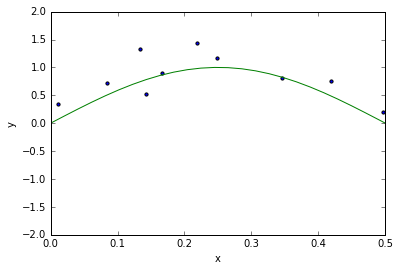

In [1]:
from __future__ import division, print_function
# отключим всякие предупреждения Anaconda
import warnings
warnings.filterwarnings('ignore')
%pylab inline
import numpy as np
import pylab as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures
from sklearn.pipeline import make_pipeline

# 11 точек
n_samples = 11

# одна из синусоид
def my_sin(x):
    return np.sin(2 * np.pi * x)

# для воспроизводимости генерации случайных точек
np.random.seed(9)

# генерируем координаты случайных точек возле синусоиды
x = np.random.uniform(0, 1, size=n_samples)[:, np.newaxis]
y = my_sin(x) + np.random.normal(scale=0.3, size=n_samples)[:, np.newaxis]

def plot_points_and_sin(x, y, f):
    ax = plt.gca()
    # точки для отображения
    x_plot = np.linspace(0, 1)
    ax.plot(x_plot, f(x_plot), color='green')
    ax.scatter(x, y, s=10)
    ax.set_ylim((-2, 2))
    ax.set_xlim((0, 0.5))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    
plot_points_and_sin(x, y, f=my_sin)

Отобразим кривые 3, 5, 7 и 9 степеней, проходящие через эти точки и минимизирующие сумму квадратов расстояний до точек. 

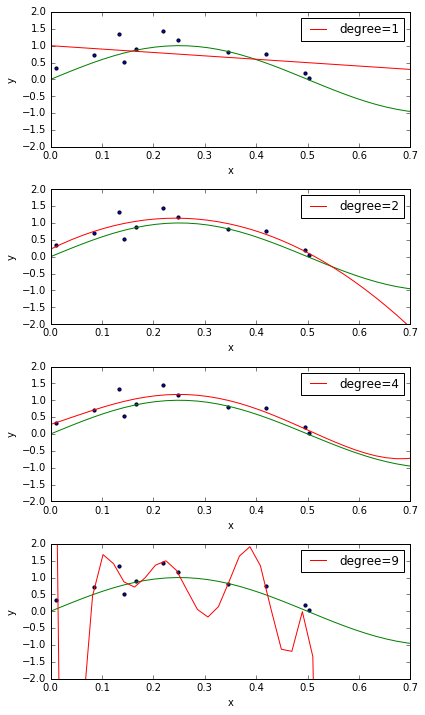

In [2]:
fig, ax_rows = plt.subplots(4, 1, figsize=(6, 10))

# функция для отображения синусоиды и регрессионной кривой
def plot_approximation(est, ax, x, y, x_plot, f, label=None):
    """Plot the approximation of ``est`` on axis ``ax``. """
    ax.plot(x_plot, f(x_plot), color='green')
    ax.scatter(x, y, s=10)
    ax.plot(x_plot, est.predict(x_plot[:, np.newaxis]), color='red', label=label)
    ax.set_ylim((-2, 2))
    ax.set_xlim((0, 0.7))
    ax.set_ylabel('y')
    ax.set_xlabel('x')
    ax.legend(loc='upper right')  #, fontsize='small')

# отображаем 4 раза
degrees = [1, 2, 4, 9]
for degree, ax_row in zip(degrees, ax_rows):
    est = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    est.fit(x, y)
    plot_approximation(est, ax_row, x, y, x_plot=np.linspace(0, 1), f=my_sin, label='degree=%r' % degree)

plt.tight_layout()

В этом примере степень полинома регрессионной кривой - по сути, сложность модели. 
В случае кривой первой степени (прямой) модель слишком простая, и она плохо обощается на точки синусоиды справа.
То есть она плохо предскажет координату `y` для точек с координатой `x` из [0.5,0.7]. 
2-я степень полинома - уже ближе, но видим, что 4-я степень лучше всего подходит для приближения синусоиды на выбранном интервале.
Кривая 9-ой степени проходит почти точно через большинство синих точек, но очень далеко от права края синусоиды. 
В этом случае модель слишком сложная, переобученная.

В этом примере одна из возможных мер регуляризации - ограничение степени полинома регрессионной кривой.

**Суть регуляризации**

Log-loss без регуляризации: $$\Large L(X, y) = \sum_{i=1}^N y^{(i)}ln(\sigma(\theta^TX_i)) + (1 - y^{(i)})ln(1 - \sigma(\theta^TX_i))$$
Log-loss с регуляризацией: $$\Large L(X, y) = \sum_{i=1}^N y^{(i)}ln(\sigma(\theta^TX_i)) + (1 - y^{(i)})ln(1 - \sigma(\theta^TX_i)) + \frac{\lambda}{2M} \sum_{j=1}^M \theta_j^2,$$
где N - число объектов, M - число признаков.

Регуляризация может не позволить параметрам модели $\theta$ достигать больших значений.

# Пример

Посмотрим, как регуляризация влияет на качество классификации, на наборе данных по тестированию микрочипов из курса Andrew Ng по машинному обучению. 
Будем использовать машину опорных векторов (SVM) с гауссовым ядром и варьировать параметр регуляризации C.
Сначала посмотрим, как регуляризация влияет на разделяющую границу классификатора, интуитивно распознаем переобучение и недообучение.
Потом численно установим ,близкий к оптимальному параметр регуляризации с помощью скользящего контроля (`cross-validation`) и сеточного перебора (`GridSearch`). 

In [14]:
import pandas as pd
from matplotlib.cm import gray
from sklearn.svm import SVC
from sklearn.cross_validation import cross_val_score, StratifiedKFold
from sklearn.grid_search import GridSearchCV

Загружаем данные с помощью метода read_csv из библиотеки pandas. В этом наборе данных для 118 микрочипов (объекты) указаны результаты двух тестов по контролю качества (два числовых признака) и сказано, пустили ли микрочип в производство. Признаки уже стандартизованы, то есть из всех значений вычтены средние по столбцам. Таким образом, "среднему" микрочипу соответсвуют нулевые значения результатов тестов.  

In [4]:
# загрузка данных
data = pd.read_csv('../../data/microchip_tests.txt',
                   header=None, names = ('test1','test2','released'))
# информация о наборе данных
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 118 entries, 0 to 117
Data columns (total 3 columns):
test1       118 non-null float64
test2       118 non-null float64
released    118 non-null int64
dtypes: float64(2), int64(1)
memory usage: 2.8 KB


Посмотрим на первые и последние 5 строк.

In [5]:
data.head(5)

,test1,test2,released
0,0.051267,0.69956,1
1,-0.092742,0.68494,1
2,-0.213710,0.69225,1
3,-0.375000,0.50219,1
4,-0.513250,0.46564,1


In [6]:
data.tail(5)

,test1,test2,released
113,-0.720620,0.538740,0
114,-0.593890,0.494880,0
115,-0.484450,0.999270,0
116,-0.006336,0.999270,0
117,0.632650,-0.030612,0


Сохраним обучающую выборку и метки целевого класса в отдельных массивах NumPy.

In [7]:
X = data.ix[:,0:2].values
y = data.ix[:,2].values

Отображаем данные. Белый цвет соответствует нормальным чипам, черный - бракованным.  

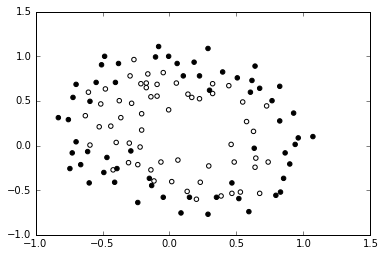

In [8]:
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=gray)

Определяем функцию для отображения разделяющей кривой классификатора

In [9]:
def plot_boundary(X, y, grid_step=.01):
    x_min, x_max = X[:, 0].min() - .1, X[:, 0].max() + .1
    y_min, y_max = X[:, 1].min() - .1, X[:, 1].max() + .1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, grid_step),
                         np.arange(y_min, y_max, grid_step))


    # каждой точке в сетке [x_min, m_max]x[y_min, y_max]
    # ставим в ссответствие свой цвет
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    plt.contour(xx, yy, Z, cmap=plt.cm.Paired)

Обучаем классификатор SVM с гауссовым ядром и параметром регуляризации С = $10^7$. (Это может занять некоторое время). Чем меньше C, тем выше регуляризация.
Также проверим долю правильных ответов классификатора на обучающей выборке.

Доля правильных ответов классификатора на обучающей выборке: 0.881


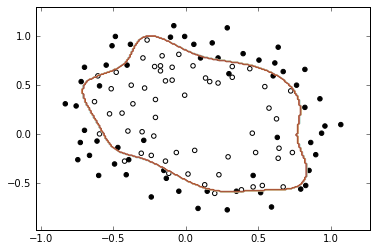

In [10]:
C = 10 ** 7  # Параметр регуляризации в SVM
# классификатор SVM с гауссовым ядром
clf = SVC(kernel = 'rbf', C=C, random_state=42)
# обучаем классификатор
clf.fit(X, y)

plot_boundary(X, y, grid_step=.01)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=gray)

print("Доля правильных ответов классификатора на обучающей выборке:", 
      round(clf.score(X, y), 3))

Видим, что классификатор сильно подстроился под обучающую выборку - правильно опредеделил метки около 88% обучающих примеров. 
Разделяющая граница сильно изогнута. Но возможно, как раз поэтому для новых чипов такой классификатор будет плохо работать.  

Теперь сделаем то же самое, но для малого параметра С = 0.2 (сильная регуляризация). 

Доля правильных ответов классификатора на обучающей выборке: 0.585


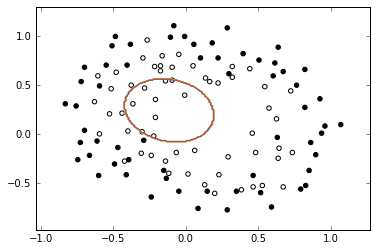

In [11]:
C = 0.2  # Параметр регуляризации в SVM
# классификатор SVM с гауссовым ядром
clf = SVC(kernel = 'rbf', C=C, random_state=42)
# обучаем классификатор
clf.fit(X, y)

plot_boundary(X, y, grid_step=.01)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=gray)

print(u"Доля правильных ответов классификатора на обучающей выборке:", 
      round(clf.score(X, y), 3))

На этот раз, наоборот, классификатор слишком слабо подстроился под обучающую выборку - правильно опредеделил метки всего около 60% обучающих примеров.
Скорее всего, такая модель тоже плохо обобщится на новые данные.

Наконец, используем параметр C=1000.

Доля правильных ответов классификатора на обучающей выборке: 0.831


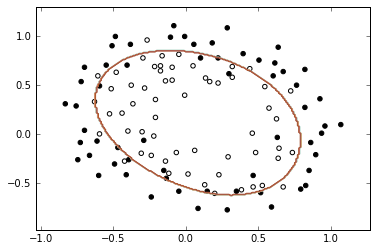

In [24]:
C = 10 # Параметр регуляризации в SVM
# классификатор SVM с гауссовым ядром
clf = SVC(kernel = 'rbf', C=C, random_state=42)
# обучаем классификатор
clf.fit(X, y)

plot_boundary(X, y, grid_step=.01)
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=gray)

print(u"Доля правильных ответов классификатора на обучающей выборке:",
      round(clf.score(X, y), 3))

На этот раз, кажется, классификатор построил неплохую плавную границу, при этом он правильно учел метки почти 86% обучающих примеров. 
Скорее всего, классификатор, обученный таким образом, лучше предскажет метки новых примеров. 

### Скользящий контроль
Посмотрим на долю правильных ответов классификации машины опорных векторов с тремя разными параметрами `C`
в процессе 5-кратного скользящего контроля. Напомним, что это значит, что обучающая выборка делится на
5 частей с сохранением пропорцими значений целевого класса. Обучение происходит 5 раз на 4 частях, а доля правильных ответов классификации проверяется на оставшейся части. 
Сравним средную долю правильных ответов классификации на скользящем контроле для трех параметров `C`.  

In [25]:
%%time
folds = StratifiedKFold(y, n_folds=5, shuffle=True, random_state=42)
scores1 = cross_val_score(SVC(C=10**7, random_state=42), X, y, scoring='accuracy', cv=folds)
print(scores1, round(scores1.mean(), 3))
scores2 = cross_val_score(SVC(C=0.2, random_state=42), X, y, scoring='accuracy', cv=folds)
print(scores2, round(scores2.mean(), 3))
scores3 = cross_val_score(SVC(C=10, random_state=42), X, y, scoring='accuracy', cv=folds)
print(scores3, round(scores3.mean(), 3))

[ 0.625       0.79166667  0.625       0.82608696  0.73913043] 0.721
[ 0.5         0.5         0.45833333  0.69565217  0.52173913] 0.535
[ 0.91666667  0.83333333  0.70833333  0.86956522  0.7826087 ] 0.822
CPU times: user 1min 10s, sys: 245 ms, total: 1min 10s
Wall time: 1min 11s


Как нам и показалось при анализе построенных разделяющих границ, при параметах  `С` = $10^7$ и `C` = 0.2 `SVM` плохо классифицирует те примеры, на которых он не обучался. 
Средняя доля правильных ответов на скользящем контроле в первом случае оказалась равной 72% во втором - всего 54%. При `С` = 10 модель лучше обобщается на новые примеры (82%).

### Поиск оптимального параметра регуляризации

Поскольку пока, к сожалению, не существует строгой теории оптимизации параметров регуляризации, на практике перебором ищут субоптимальные параметры. 
Конечно, это вычислительно сложно. Также сложность в том, что надо хотя бы примерно знать, где искать, то есть в каком диапазоне значений. 
Как вы увидели, на скользящем контроле выше доля правильных ответов классификации получилась при параметре `C`=10. 
Будем перебирать 50 значений `C` от $10^-1$ до $10^2$ и использовать 5-кратный скользящий контроль. Это в сумме 2500 обучений модели. 

In [28]:
%%time
parameters = {'kernel': ['rbf'], 'C': np.logspace(-1, 2, 500),
             'random_state': [42]}
grid_search_svm = GridSearchCV(SVC(), 
                               parameters, cv=folds, verbose=1, n_jobs=-1)
grid_search_svm.fit(X,y)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Done 624 tasks      | elapsed:    1.6s


CPU times: user 4.59 s, sys: 972 ms, total: 5.57 s
Wall time: 4.92 s


[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    4.7s finished


**Видим, что среди выбранных значений параметра лучшим оказалось `C` =~ 8.75.**

In [35]:
print("Лучшие параметры и доля правильных ответов классификации на скользящем контроле: {0}, {1}"
      .format(grid_search_svm.best_params_, 
              round(grid_search_svm.best_score_, 5)))

Лучшие параметры и доля правильных ответов классификации на скользящем контроле: {'kernel': 'rbf', 'C': 8.7474963015544205, 'random_state': 42}, 0.83051


**Для более точного нахождения "хорошего" значения параметра повторим поиск в диапазоне [5, 10].**

In [33]:
%%time
parameters_finer = {'kernel': ['rbf'], 'C': np.linspace(5, 10, 500),
                   'random_state': [42]}
grid_search_svm_finer = GridSearchCV(SVC(), 
                                     parameters_finer, 
                                     cv=folds, verbose=1, n_jobs=-1)
grid_search_svm_finer.fit(X,y)

Fitting 5 folds for each of 500 candidates, totalling 2500 fits


[Parallel(n_jobs=-1)]: Done 832 tasks      | elapsed:    2.0s


CPU times: user 4.62 s, sys: 1.02 s, total: 5.64 s
Wall time: 4.92 s


[Parallel(n_jobs=-1)]: Done 2500 out of 2500 | elapsed:    4.8s finished


In [34]:
print("Лучшие параметры и доля правильных ответов классификации классификации на скользящем контроле: {0}, {1}"
      .format(grid_search_svm_finer.best_params_, 
              round(grid_search_svm_finer.best_score_, 5)))

Лучшие параметры и доля правильных ответов классификации классификации на скользящем контроле: {'kernel': 'rbf', 'C': 8.6272545090180355, 'random_state': 42}, 0.83051


**Видим, что последний перебор параметов уже не улучшил долю правильных ответов на скользящем контроле, то есть параметр регуляризации C найден хорошо.**